# Set Up

### import, config, sparksession, table reading

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import pyspark
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import col, hex, base64, avg, collect_list, concat, lit, mean
from pyspark.sql.types import StructType,StructField, StringType, IntegerType, LongType
import pyspark.sql.functions as F 


In [2]:
#config for our sparksession
config = pyspark.SparkConf().setAll([
    ('spark.executor.memory', '12g'), 
    ('spark.executor.cores', '2'), 
    ('spark.cores.max', '4'),
    ('spark.driver.memory','2g'),
    ('spark.executor.instances', '1'),
    ('spark.dynamicAllocation.enabled', 'true'),
    ('spark.dynamicAllocation.shuffleTracking.enabled', 'true'),
    ('spark.dynamicAllocation.executorIdleTimeout', '60s'),
    ('spark.dynamicAllocation.minExecutors', '1'),
    ('spark.dynamicAllocation.maxExecutors', '2'),
    ('spark.dynamicAllocation.initialExecutors', '1'),
    ('spark.dynamicAllocation.executorAllocationRatio', '1'),
    ('spark.worker.cleanup.enabled', 'true'),
    ('spark.worker.cleanup.interval', '60'),
    ('spark.shuffle.service.db.enabled', 'true'),
    ('spark.worker.cleanup.appDataTtl', '60'),
    ('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector:10.0.2')
])

In [3]:
#create sparksession
#when copying change appName
spark = SparkSession \
    .builder \
    .config(conf=config) \
    .appName("balanceDistr") \
    .master("spark://172.23.149.212:7077") \
    .getOrCreate()

22/07/07 16:58:44 WARN Utils: Your hostname, algorand-druid-and-spark resolves to a loopback address: 127.0.0.1; using 172.23.149.212 instead (on interface ens3)
22/07/07 16:58:44 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/home/ubuntu/.local/lib/python3.8/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/ubuntu/.ivy2/cache
The jars for the packages stored in: /home/ubuntu/.ivy2/jars
org.mongodb.spark#mongo-spark-connector added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-b083de81-e21c-4bbf-b425-7f75b1fee02b;1.0
	confs: [default]
	found org.mongodb.spark#mongo-spark-connector;10.0.2 in central
	found org.mongodb#mongodb-driver-sync;4.5.1 in central
	[4.5.1] org.mongodb#mongodb-driver-sync;[4.5.0,4.5.99)
	found org.mongodb#bson;4.5.1 in central
	found org.mongodb#mongodb-driver-core;4.5.1 in central
:: resolution report :: resolve 3134ms :: artifacts dl 23ms
	:: modules in use:
	org.mongodb#bson;4.5.1 from central in [default]
	org.mongodb#mongodb-driver-core;4.5.1 from central in [default]
	org.mongodb#mongodb-driver-sync;4.5.1 from central in [default]
	org.mongodb.spark#mongo-spark-connector;10.0.2 from central in [default]
	---------------------------------------------------------------------
	|                  | 

In [4]:
# account table to determine which accounts have the highest balances
dfAccounts = spark.read.format("mongodb") \
    .option('spark.mongodb.connection.uri', 'mongodb://172.23.149.212:27017') \
    .option('spark.mongodb.database', 'algorand') \
    .option('spark.mongodb.collection', 'account') \
    .option('park.mongodb.read.readPreference.name', 'primaryPreferred') \
    .option('spark.mongodb.change.stream.publish.full.document.only','true') \
    .option("forceDeleteTempCheckpointLocation", "true") \
    .load()


# Organizing Table

In [5]:
# drop all unneccessary columns
dfAccounts = dfAccounts.drop("_id","rewardsbase", "account_data", "rewards_total", "deleted", "closed_at", "keytype")

# calculate hom many algos are on the chain, and print the amount of algos on the chain
    
totalAlgos = dfAccounts.agg(F.sum("microalgos")).collect()[0][0]
#summ = dfAccounts.select(F.sum("microalgos")).show()
#print("this are the total mAlgos: ", totalAlgos)

#add column and calculate the proportion of the account to all algos, proportion is in %
dfAccounts = dfAccounts.withColumn("proportion", dfAccounts.microalgos/totalAlgos*100)

totalAccounts = dfAccounts.count()
#printAccount Types and the table sorted in descending order
#print("how many addresses are in the Algorand network?", totalAccounts)




### Write the Result in a Gold Table

In [6]:
newestRound = dfAccounts.agg(F.max("created_at")).collect()[0][0]

In [7]:
#write amount of Algos in gold table
#first put value in a df
result = spark.createDataFrame(
    [
        (totalAlgos, totalAlgos/1000, totalAccounts, newestRound)  # create your data here, be consistent in the types.
        
    ],
    ["totalMicroAlgos", "totalAlgos", "totalAccounts", "CreationRound"]  # add your column names here
)

result.write.format("mongodb") \
	.option('spark.mongodb.connection.uri', 'mongodb://172.23.149.212:27017') \
  	.mode("append") \
    .option('spark.mongodb.database', 'algorand_gold') \
  	.option('spark.mongodb.collection', '3_TotalAlgos') \
  	.option("forceDeleteTempCheckpointLocation", "true") \
  	.save()


22/07/07 17:00:34 WARN CaseInsensitiveStringMap: Converting duplicated key forcedeletetempcheckpointlocation into CaseInsensitiveStringMap.


In this table all addresses in the Algroand network are represented. The addresses are sorted by their account balance, starting with the largest one. In the last column their account balance is counterposed to the total amounts of Algos in the network. Therefore a centralisation of assets could be distinguished with this table.

# Plotting Balance Distribution

### Preparation

In [8]:
#everything with 0
dataWith0Accounts = dfAccounts.select("microalgos")
dataWith0Accounts = dataWith0Accounts.collect()

#convert row["data"] to only data
microalgos0 = [row[0] for (row) in dataWith0Accounts]
mean_alg0 = dfAccounts.agg(F.mean("microalgos")).collect()[0][0]

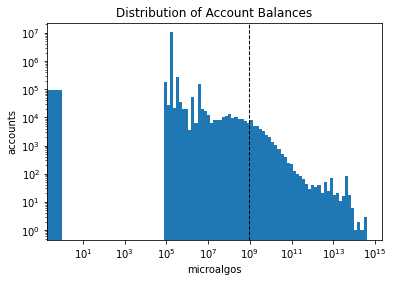

In [9]:
#histogram with all accounts
#how many bars in the histogram should be plotted
#histogram
bin_size = 100
#plus one so no 0 value is created
mybins = np.logspace(0, np.log10(max(microalgos0)), bin_size )


mybins = np.insert(mybins, 0, 0)


plt.hist(microalgos0, bins = mybins)
#plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
plt.xscale('log')
plt.yscale('log')
plt.xlabel("microalgos")
plt.ylabel("accounts")
plt.title("Distribution of Account Balances", loc ='center', pad = None)
plt.axvline(mean_alg0, color='k', linestyle='dashed', linewidth=1)
plt.savefig('/home/ubuntu/apps/figures/3_BalanceDistribution/Distribution_AccountBalances_incl_0.jpg', dpi= 200)
plt.show()

In [10]:
#cell with no 0 values
#get rid off 0 values because they aredestroying the plot
dfAccNoZero = dfAccounts.filter(dfAccounts.microalgos > 0)

#graph
dataWithout0Accounts = dfAccNoZero.select("microalgos")
dataWithout0Accounts = dataWithout0Accounts.collect()

#convert row["data"] to only data
microalgos = [row[0] for (row) in dataWithout0Accounts]

#calculate the mean of all accounts with a balance > 0
mean_alg = dfAccNoZero.agg(F.mean("microalgos")).collect()[0][0]

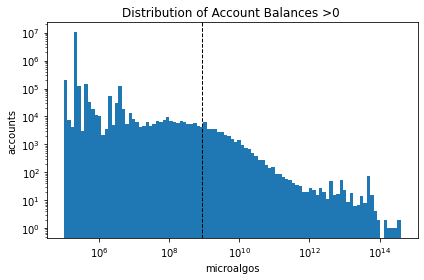

In [11]:
#histogram with all accounts with an amount > 0
#how many bars in the histogram should be plotted
#histogram
bin_size = 100
#distribute bins log(equally) over the whole data
mybins = np.logspace(np.log10(min(microalgos)), np.log10(max(microalgos)), bin_size )
plt.hist(microalgos, bins = mybins)
#plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
plt.xscale('log')
plt.yscale('log')
plt.xlabel("microalgos")
plt.ylabel("accounts")
plt.title("Distribution of Account Balances >0 ", loc ='center', pad = None)
plt.axvline(mean_alg, color='k', linestyle='dashed', linewidth=1)
plt.savefig('/home/ubuntu/apps/figures/3_BalanceDistribution/Distribution_AccountBalances_excl_0.jpg', dpi= 200)
plt.show()

In [12]:
#graph select only account balances, sort it from highest to lowest and take the highest 10 balances
whalesData = dfAccounts.select("microalgos", "addr").sort(col("microalgos").desc()).head(10)
#graph = graph.head(10)
#graph = graph.collect()
#show the wahles


#convert row["data"] to only data /1000 to reach algos from microalgos
whales = [row[0]/1000 for (row) in whalesData]
whalesAddresses = [row[1] for (row) in whalesData]


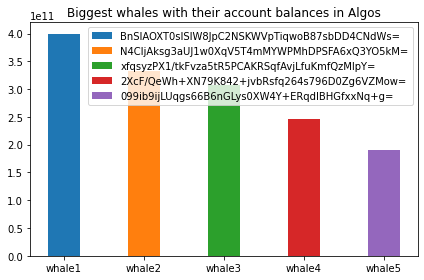

In [13]:
#save the whales, the top 10 whales are saved in a list
plt.bar("whale1", whales[0], width = 0.4)
plt.bar("whale2", whales[1], width = 0.4)
plt.bar("whale3", whales[2], width = 0.4)
plt.bar("whale4", whales[3], width = 0.4)
plt.bar("whale5", whales[4], width = 0.4)
plt.rcParams["figure.figsize"] = (10, 5)
plt.title("Biggest whales with their account balances in Algos", loc ='center', pad = None)

plt.legend([whalesAddresses[0], whalesAddresses[1], whalesAddresses[2],whalesAddresses[3],whalesAddresses[4]])
plt.savefig('/home/ubuntu/apps/figures/3_BalanceDistribution/Distribution_whales.jpg', dpi= 200)
plt.show()

In [14]:
spark.stop()